## Стартап по продаже продуктов питания в интернете

## План работы:

### Шаг 1. Загрузка данных и подготовка к анализу

###  Шаг 2. Анализ данных:
    2.1 Количество событий, количество пользователей в логе, среднее количество событий на пользователя
    2.2 Воронка событий
        2.2.1 События в логах, частота событий, сортировка
        2.2.2 Количество пользователей совершивших каждое событие, сортировка событий по числу пользователей, доли пользователей, совершивших событие
        2.2.3 Воронка событий, визуализация
        
### Шаг 3.  Изучение результатов эксперимента     
    3.1 Количество пользователей в каждой экспериментальной группе
    3.2 Сравнение контрольных групп
        3.2.1 Сравнение по каждому событию
    3.3 Сравнение результатов экспериментальной группы с каждой из контрольных групп в отдельности по каждому событию
    3.4 Сравнение результатов экспериментальной группы с объединенной контрольной группой
    
### Вывод    

#### Описание данных:

    EventName — название события;
    DeviceIDHash **— уникальный идентификатор пользователя;
    EventTimestamp — время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
from scipy import stats as st
import numpy as np
import math as mth
pd.options.mode.chained_assignment = None  

### Шаг 1. Загрузка данных и подготовка к анализу

In [165]:
path = 'C://Users//1//Desktop//'
logs_data = pd.read_csv(path + 'logs_exp.csv',sep= '\t')

In [166]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [167]:
logs_data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Пропусков нет, названия столбцов не в питоновском формате. Столбец 'EventTimestamp' необходимо приводить в читаемый вид.

In [168]:
# заменяю названия столбцов
logs_data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_ID',
                          'EventTimestamp':'event_timestamp','ExpId':'exp_ID'}, inplace=True)

In [169]:
# заменяю формат данных
logs_data['user_ID'] = logs_data['user_ID'].astype('uint64')
logs_data['exp_ID'] = logs_data['exp_ID'].astype('uint64')
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name         244126 non-null object
user_ID            244126 non-null uint64
event_timestamp    244126 non-null int64
exp_ID             244126 non-null uint64
dtypes: int64(1), object(1), uint64(2)
memory usage: 7.5+ MB


In [170]:
# добавлю столбец 'дата' и столбец 'дата и время'
logs_data['time'] = pd.to_datetime(logs_data['event_timestamp'], unit='s')
logs_data['date'] = pd.to_datetime(logs_data['event_timestamp'], unit='s').apply(lambda x: x.date())
logs_data.head(5)

,event_name,user_ID,event_timestamp,exp_ID,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


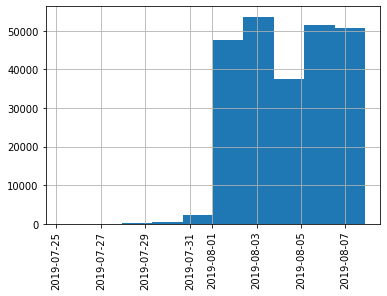

In [171]:
# временной период выгрузки логов
logs_data['time'].hist()
plt.xticks(rotation=90);

По гистограмме видно, что основной поток данных начинается с 08.01. Буду убирать данные с более раннего периода. 

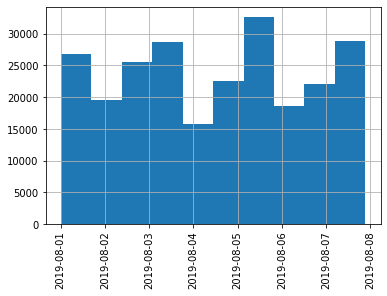

In [172]:
# фильтр на 01.08
logs_data_complete = logs_data.query('time >= "2019-08-01"')
logs_data_complete['time'].hist()
plt.xticks(rotation=90);

In [173]:
# количество потерянных данных
logs_data_lost = logs_data.query('time <= "2019-08-01"')
print('Количество событий до применения фильтра',len(logs_data))
print('Количество потерянных событий',len(logs_data_lost))
print('Процент потерянных событий -',round(len(logs_data_lost)/len(logs_data)*100,2))

Количество событий до применения фильтра 244126
Количество потерянных событий 2828
Процент потерянных событий - 1.16


In [174]:
# начилие пользователей в каждой из экспериментальных групп
logs_data_complete.pivot_table(index = 'exp_ID',values='user_ID', aggfunc='count')

,user_ID
exp_ID,
246,79425
247,77147
248,84726


###  Шаг 2. Анализ данных:
##### 2.1 Количество событий, количество пользователей в логе, среднее количество событий на пользователя

In [175]:
print('Количество событий в логе -',len(logs_data_complete.event_name.unique()))
print('Количество пользователей в логе -',len(logs_data_complete.user_ID.unique()))
print('Среднее количество событий на пользователя -',round(len(logs_data_complete) /
      len(logs_data_complete.user_ID.unique())))

Количество событий в логе - 5
Количество пользователей в логе - 7534
Среднее количество событий на пользователя - 32


##### 2.2 Воронка событий

##### 2.2.1 События в логах, частота событий, сортировка

In [176]:
logs_data_complete.pivot_table(index = 'event_name',values='user_ID', 
                               aggfunc='count').reset_index().sort_values('user_ID', ascending = False)

,event_name,user_ID
1,MainScreenAppear,117431
2,OffersScreenAppear,46350
0,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


##### 2.2.2 Количество пользователей совершивших каждое событие, сортировка событий по числу пользователей, доли пользователей, совершивших событие

In [177]:
logs_data_complete_group = logs_data_complete.groupby('event_name').agg(
    {'user_ID':'nunique'}).reset_index().sort_values('user_ID', ascending = False)
# число пользователей совершивших событие / общее число пользователей
logs_data_complete_group['ratio'] = round(logs_data_complete_group['user_ID'] / len(logs_data_complete
                                                                              ['user_ID'].unique()),2)
logs_data_complete_group

,event_name,user_ID,ratio
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Если предположить, что обучение (Tutorial) происходит после первого визита и по желанию пользователя, то получим следующую последовательность.
1. MainScreenAppear
2. Tutorial
3. OffersScreenAppear
4. CartScreenAppear
5. PaymentScreenSuccessful	
В таком случае, связь между Tutorial и другими этапами воронки продаж отсутствует и правильно бы было удалить этот пункт.

In [178]:
# удаляю Tutorial
logs_data_complete_group = logs_data_complete_group.drop(logs_data_complete_group.index[[4]])
logs_data_complete_group = logs_data_complete_group.reset_index()
logs_data_complete = logs_data_complete.query('event_name != "Tutorial"')

##### 2.2.3 Воронка событий, визуализация

In [179]:
# отношение количества пользователей на каждом шаге к общему количеству пользователей
a = round(logs_data_complete_group.loc[0,'user_ID'] /len(logs_data_complete['user_ID'].unique()),2)
a_b = round(logs_data_complete_group.loc[1,'user_ID'] /len(logs_data_complete['user_ID'].unique()),2)
a_c = round(logs_data_complete_group.loc[2,'user_ID'] /len(logs_data_complete['user_ID'].unique()),2)
a_d = round(logs_data_complete_group.loc[3,'user_ID'] /len(logs_data_complete['user_ID'].unique()),2)

In [180]:
data = dict(
    step=[a,a_b,a_c,a_d],
    name_step=["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear","PaymentScreenSuccessful"])
fig = px.funnel(data, x='step', y='name_step')
fig.show()

До оплаты доходит 47 % пользователей. Самое большое количество пользователей теряется на втором шаге 'OffersScreenAppear'.
Почти половина пользователей проходят путь от посещения сайта до оплаты покупки. Такие высокие показатели могут объясняться сферой, в которой работает сайт, продукты питания - это товар повседневного спроса. Часть пользователей теряется на этапе ввода данных карты оплаты, этому стоит уделить внимание, т.к. на этом этапе решение о покупке уже принято, тем не менее часть пользователей отказывается от покупки. 

### Шаг 3.  Изучение результатов эксперимента     

##### 3.1 Количество пользователей в каждой экспериментальной группе

In [181]:
logs_data_complete_exp = logs_data_complete.groupby('exp_ID').agg(
    {'user_ID':'nunique'}).reset_index().sort_values('user_ID', ascending = False)
logs_data_complete_exp = logs_data_complete_exp.reset_index(drop=True)
logs_data_complete_exp

,exp_ID,user_ID
0,248,2535
1,247,2512
2,246,2483


##### 3.2 Сравнение контрольных групп

В исследовании будет проведено 17 сравнений. Пояснения по применяемой поправке написаны в пункте 

In [182]:
# уровень значимости
a_sh = 1 - ( 1 - 0.05 ) ** ( 1 / 17)
a_sh

0.0030127052790058784

In [183]:
# универсальная функция для сравнения
def test(successes1, successes2, trials1, trials2):
    alpha = a_sh
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение: ', p_value)
    
    print(successes1/trials1)
    print(successes2/trials2)
 
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")   

In [184]:
# сохраняю данные по группам в отдельные переменные
logs_data_complete_246 = logs_data_complete.query('exp_ID == "246"')
logs_data_complete_247 = logs_data_complete.query('exp_ID == "247"')

In [185]:
# взял количество пользователей в группах 246, и 247 для обозначения successes
# для обозначения trials использую общее количество пользователей
test(len(logs_data_complete_246['user_ID'].unique()), len(logs_data_complete_247['user_ID'].unique()),
len(logs_data_complete['user_ID'].unique()), len(logs_data_complete['user_ID'].unique()))

p-значение:  0.6157227013842994
0.3297476759628154
0.33359893758300135
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Z-тест не дает оснований считать выборки разными, учитывая, что уровень статзначимости выставлен с учетом поправок на множественные сравнения, можно говорить о том, что различия между выборками маловероятны.

##### 3.2.1 Сравнение по каждому событию

In [186]:
# количество уникальных пользователей по каждому событию в каждой из контрольных групп
logs_data_complete_exp246 = logs_data_complete_246.groupby('event_name').agg(
    {'user_ID':'nunique'}).reset_index().sort_values('user_ID', ascending = False)
logs_data_complete_exp247 = logs_data_complete_247.groupby('event_name').agg(
    {'user_ID':'nunique'}).reset_index().sort_values('user_ID', ascending = False)
logs_data_complete_exp246 = logs_data_complete_exp246.reset_index(drop=True)
logs_data_complete_exp247 = logs_data_complete_exp247.reset_index(drop=True)
# общее количество пользователей в контрольных группах
total_users_247 =  logs_data_complete_exp.loc[1,'user_ID']
total_users_246 = logs_data_complete_exp.loc[2,'user_ID']

In [187]:
group_246 = logs_data_complete_exp246['user_ID']
group_247 = logs_data_complete_exp247['user_ID']
name_event = logs_data_complete['event_name'].unique()

In [188]:
print('Сравнение групп 246 и 247') 
for i in range(len(group_247)):
    print(name_event [i])
    test(group_246[i], group_247[i],total_users_246, total_users_247)

Сравнение групп 246 и 247
MainScreenAppear
p-значение:  0.7526703436483038
0.9867096254530809
0.9856687898089171
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  0.24786096925282264
0.6210229561014902
0.6050955414012739
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear
p-значение:  0.22867643757335676
0.5098670962545309
0.4928343949044586
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  0.11446627829276612
0.4832863471606927
0.4609872611464968
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнения по всем 4-м событиям не выявили значимых различий между контрольными группами.

##### 3.3 Сравнение результатов экспериментальной группы с каждой из контрольных групп в отдельности по каждому событию

In [189]:
# в отдельную переменную сохраняю данные группы 248 
logs_data_complete_248 = logs_data_complete.query('exp_ID == "248"')
# считаю количество пользователей в группе 248
logs_data_complete_exp248 = logs_data_complete_248.groupby('event_name').agg(
    {'user_ID':'nunique'}).reset_index().sort_values('user_ID', ascending = False)
logs_data_complete_exp248 = logs_data_complete_exp248.reset_index(drop=True)
# количество пользователей совршивших события
group_248 = logs_data_complete_exp248['user_ID']
total_users_248 = logs_data_complete_exp.loc[0,'user_ID']

In [190]:
print('Сравнение групп 246 и 248') 
for i in range(len(group_246)):
    print(name_event [i])
    test(group_246[i], group_248[i],total_users_246, total_users_248)

Сравнение групп 246 и 248
MainScreenAppear
p-значение:  0.3387114076159288
0.9867096254530809
0.9834319526627219
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  0.21442476639710506
0.6210229561014902
0.6039447731755424
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear
p-значение:  0.08067367598823139
0.5098670962545309
0.48520710059171596
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  0.21693033984516674
0.4832863471606927
0.4658777120315582
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [191]:
print('Сравнение групп 247 и 248') 
for i in range(len(group_246)):
    print(name_event [i])
    test(group_247[i], group_248[i],total_users_247, total_users_248)

Сравнение групп 247 и 248
MainScreenAppear
p-значение:  0.5194964354051703
0.9856687898089171
0.9834319526627219
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  0.9333751305879443
0.6050955414012739
0.6039447731755424
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear
p-значение:  0.5878284605111943
0.4928343949044586
0.48520710059171596
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  0.7275718682261119
0.4609872611464968
0.4658777120315582
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### 3.4 Сравнение результатов экспериментальной группы с объединенной контрольной группой

In [192]:
# объединяю данные из двух контрольных групп
logs_data_complete_exp246_247 = logs_data_complete_exp246.merge(logs_data_complete_exp247, on ='event_name')
logs_data_complete_exp246_247['step_total_246_247'] = logs_data_complete_exp246_247[
    'user_ID_x'] + logs_data_complete_exp246_247['user_ID_y']
step_total_246_247 = logs_data_complete_exp246_247['step_total_246_247']
# считаю общее количество пользователей в контрольных группах
total_246_247 = logs_data_complete_exp.loc[1,'user_ID'] + logs_data_complete_exp.loc[2,'user_ID']

In [193]:
print('Сравнение групп 246-247 и 248') 
for i in range(len(group_246)):
    print(name_event [i])
    test(step_total_246_247[i],
         group_248[i],total_246_247, total_users_248)

Сравнение групп 246-247 и 248
MainScreenAppear
p-значение:  0.3486684291093256
0.9861861861861861
0.9834319526627219
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear
p-значение:  0.44582745409482394
0.613013013013013
0.6039447731755424
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear
p-значение:  0.18683558686831558
0.5013013013013013
0.48520710059171596
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful
p-значение:  0.6107918742187335
0.4720720720720721
0.4658777120315582
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Z-тест не дает оснований считать, что экспериментальная группа имеет различия с контрольными группами.

##### 3.5 Уровень значимости

Общее количество стравнений 17. Для того, чтобы сохранить мощность теста и уменьшить групповую вероятность ошибки первого рода, использую метод Шидака.

In [194]:
a_sh = 1 - ( 1 - 0.05 ) ** ( 1 / 17)
a_sh

0.0030127052790058784

### Вывод
До покупки доходит 47 % пользователей. Самое большое количество потенциальных покупателей отсеивается на этапе выбора товара. Проведенные тесты не дают оснований считать, что изменение шрифта оказывает влияние на конверсию. 